In [9]:
from torchvision.transforms import functional as F
from PIL import Image

def load_and_preprocess_image(image_path):
    # Load image
    img = Image.open(image_path)
    
    # Convert to tensor
    return F.to_tensor(img)


In [18]:
import torchvision
# from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch

def get_model_instance_segmentation(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    model = maskrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    
    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


def load_trained_model(model_path, num_classes):
    # Load a model; assuming model architecture is known
    model = get_model_instance_segmentation(num_classes)
    
    # Load trained weights
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

In [19]:
def predict(model, img, device):
    model.eval()
    model.to(device)
    img = img.unsqueeze(0)  # Add batch dimension
    img = img.to(device)
    with torch.no_grad():
        prediction = model(img)
    return prediction

In [20]:
model = load_trained_model("./save/2024-05-04-0221_model_epoch_9.pth", 26)

In [29]:
img = load_and_preprocess_image("./data/Training/원천데이터_3/펑크/1031246.jpg")
p = predict(model, img, "cpu")

In [30]:
p[0]

{'boxes': tensor([[197.1334,  30.9865, 532.6686, 486.8022],
         [ 16.1984, 360.8925, 541.3795, 821.3337],
         [ 14.5457,  23.5179, 557.9158, 837.5586],
         [ 78.6721,  50.2949, 562.3879, 666.3208],
         [158.2020,  25.4267, 536.8089, 527.2107],
         [ 48.6275,  81.3351, 549.5416, 740.3194],
         [193.7402,   5.4671, 526.3462, 480.8203],
         [196.2223,  69.5047, 524.3989, 461.1446],
         [ 19.3083, 381.8447, 468.2310, 778.9080],
         [ 63.8234, 356.0756, 541.8850, 834.3199]]),
 'labels': tensor([13,  9, 19, 13, 19,  9,  2,  9, 19,  2]),
 'scores': tensor([0.8570, 0.8229, 0.6677, 0.2695, 0.2001, 0.1456, 0.1348, 0.1003, 0.0618,
         0.0581]),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0.,

In [44]:
for box, mask in zip(p[0]['boxes'], p[0]["masks"][0][0]):
    print(box)
    print(mask)
    print()

tensor([197.1334,  30.9865, 532.6686, 486.8022])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.,

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample(img, target):
    plt.imshow(img.permute(1, 2, 0))  # permute to change CxHxW to HxWxC
    for box, mask in zip(target['boxes'], target['masks'][0]):
        plt.imshow(mask, alpha=0.5)  # Show mask
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color='red')
        plt.gca().add_patch(rect)
    plt.show()

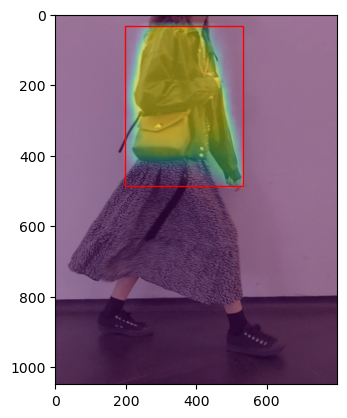

NameError: name 'idx' is not defined

In [45]:
# Assuming img and target are your batch outputs
show_sample(img, p[0])  # Visualize first item in the batch
print(idx)